In [ ]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.regularizers import l2
#Data handling tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam, SGD, RMSprop

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data_path = "F:\\Mahi\\brain mri\\T1 3064 blurred\\train"

filepaths =[]

labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_data_path = "F:\\Mahi\\brain mri\\T1 3064 blurred\\test"


filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
img_size = (224 ,224)
batch_size = 16

ts_gen= ImageDataGenerator()

tr_gen= ImageDataGenerator()
# Create an instance of the ImageDataGenerator

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size, class_mode = 'categorical' ,
                                      color_mode= 'rgb', shuffle = False , batch_size = batch_size)

Found 2451 validated image filenames belonging to 3 classes.
Found 613 validated image filenames belonging to 3 classes.


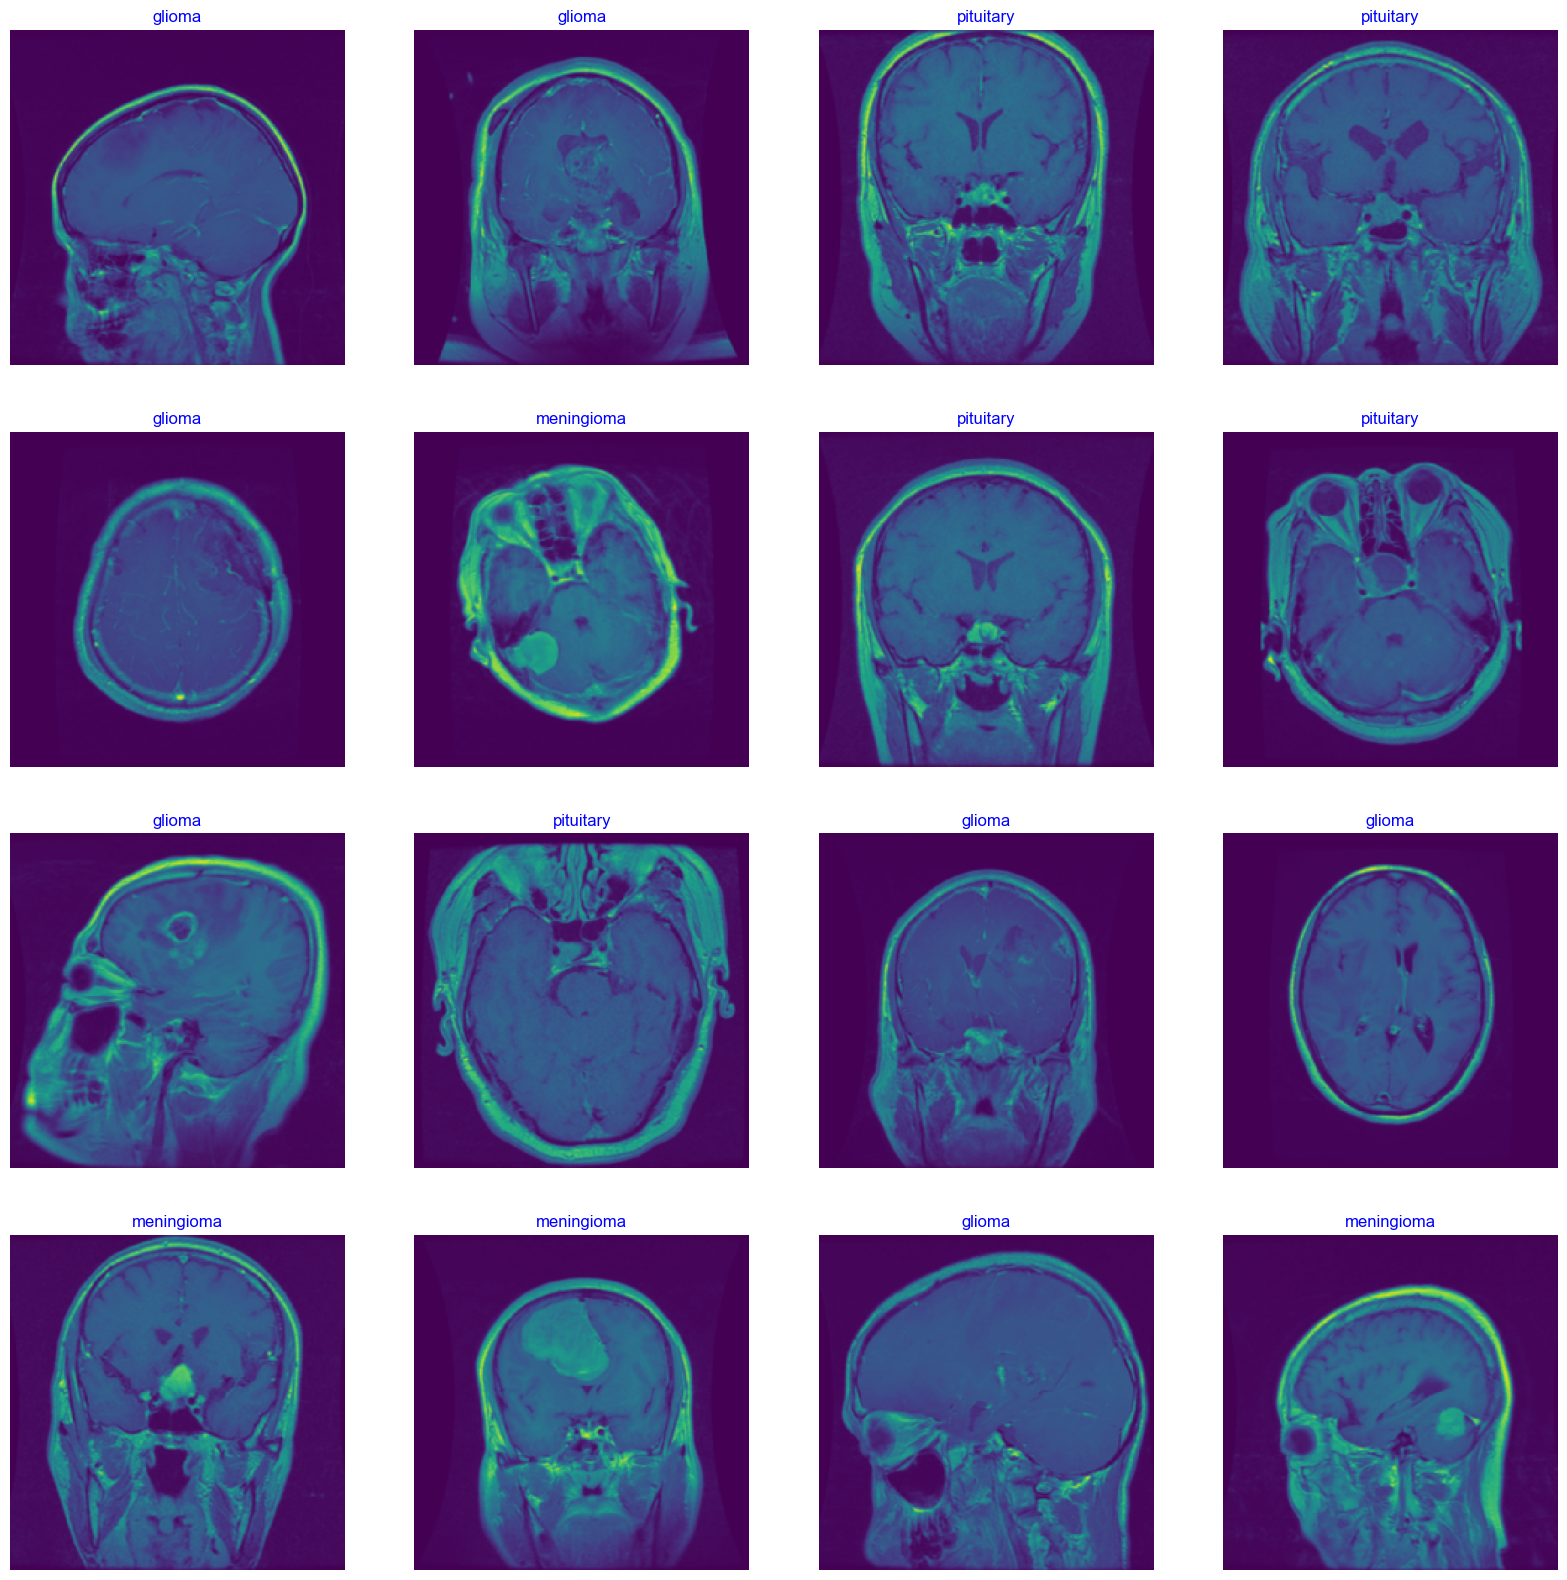

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
#plt.savefig("/content/drive/MyDrive/Dataset.jpg")
plt.show();
# plt.savefig("/content/drive/MyDrive/Dataset.jpg")

In [ ]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# Specify the path to save the best model weights
checkpoint_filepath = 'F:\\Mahi\\brain mri\\cnn7022.h5'
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
# Set up the ModelCheckpoint callback to save weights with the highest validation accuracy
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
model3 = Sequential()
model3.add(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 1.3282 - accuracy: 0.7647
Epoch 1: val_accuracy improved from -inf to 0.46493, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 25s 141ms/step - loss: 1.3282 - accuracy: 0.7647 - val_loss: 131.4845 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.8345
Epoch 2: val_accuracy did not improve from 0.46493
119/119 [==============================] - 13s 106ms/step - loss: 0.4827 - accuracy: 0.8345 - val_loss: 269.0525 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 2.2899 - accuracy: 0.7144
Epoch 3: val_accuracy did not improve from 0.46493
119/119 [==============================] - 13s 107ms/step - loss: 2.2899 - accuracy: 0.7144 - val_loss: 176.1897 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 4/100
119/119 [==============================] - ETA: 0s

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.859155  0.871429  0.865248       140
           1   0.947368  0.954064  0.950704       283
           2   0.967742  0.947368  0.957447       190

    accuracy                       0.933116       613
   macro avg   0.924755  0.924287  0.924466       613
weighted avg   0.933537  0.933116  0.933277       613



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
model3 = Sequential()
model3.add(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 2.1432 - accuracy: 0.4648
Epoch 1: val_accuracy improved from -inf to 0.45677, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 18s 119ms/step - loss: 2.1432 - accuracy: 0.4648 - val_loss: 1.0521 - val_accuracy: 0.4568 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.8542 - accuracy: 0.6224
Epoch 2: val_accuracy improved from 0.45677 to 0.72431, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 13s 108ms/step - loss: 0.8542 - accuracy: 0.6224 - val_loss: 0.6581 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.7356
Epoch 3: val_accuracy did not improve from 0.72431
119/119 [==============================] - 13s 105ms/step - loss: 0.6279 - accuracy: 0.7356 - val_loss: 0.6828 - val_accuracy: 0.6754 - lr: 0.0010
Epoch 4/100
119/11

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.549296  0.600000  0.573529       130
           1   0.817544  0.789831  0.803448       295
           2   0.892473  0.882979  0.887701       188

    accuracy                       0.778140       613
   macro avg   0.753104  0.757603  0.754893       613
weighted avg   0.783636  0.778140  0.780528       613



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
model3 = Sequential()
model3.add(VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 3.1100 - accuracy: 0.4527
Epoch 1: val_accuracy improved from -inf to 0.42741, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 19s 113ms/step - loss: 3.1100 - accuracy: 0.4527 - val_loss: 1.0585 - val_accuracy: 0.4274 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.9365 - accuracy: 0.5780
Epoch 2: val_accuracy improved from 0.42741 to 0.59869, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 13s 112ms/step - loss: 0.9365 - accuracy: 0.5780 - val_loss: 0.8346 - val_accuracy: 0.5987 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.7033
Epoch 3: val_accuracy did not improve from 0.59869
119/119 [==============================] - 13s 104ms/step - loss: 0.6681 - accuracy: 0.7033 - val_loss: 0.8429 - val_accuracy: 0.5791 - lr: 0.0010
Epoch 4/100
119/11

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.556338  0.669492  0.607692       118
           1   0.849123  0.796053  0.821732       304
           2   0.913978  0.890052  0.901857       191

    accuracy                       0.800979       613
   macro avg   0.773146  0.785199  0.777094       613
weighted avg   0.812971  0.800979  0.805496       613



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#ResNwt152V2

In [ ]:
from tensorflow.keras.applications import ResNet152V2
model3 = Sequential()
model3.add(ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 1.7188 - accuracy: 0.5854
Epoch 1: val_accuracy did not improve from 0.46493
119/119 [==============================] - 28s 129ms/step - loss: 1.7188 - accuracy: 0.5854 - val_loss: 546809053184.0000 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 1.0660 - accuracy: 0.6764
Epoch 2: val_accuracy improved from 0.46493 to 0.54323, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 19s 161ms/step - loss: 1.0660 - accuracy: 0.6764 - val_loss: 22.3466 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.7636
Epoch 3: val_accuracy did not improve from 0.54323
119/119 [==============================] - 13s 109ms/step - loss: 0.7130 - accuracy: 0.7636 - val_loss: 1.0526 - val_accuracy: 0.4666 - lr: 0.0010
Epoch 4/100
119/119 [==============================] 

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.711268  0.664474  0.687075       152
           1   0.866667  0.854671  0.860627       289
           2   0.752688  0.813953  0.782123       172

    accuracy                       0.796085       613
   macro avg   0.776874  0.777699  0.776608       613
weighted avg   0.796153  0.796085  0.795566       613



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#ResNet101V2

In [ ]:
from tensorflow.keras.applications import ResNet101V2
model3 = Sequential()
model3.add(ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.7705
Epoch 1: val_accuracy improved from -inf to 0.41925, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 29s 152ms/step - loss: 0.8296 - accuracy: 0.7705 - val_loss: 5148.2788 - val_accuracy: 0.4192 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 1.9869 - accuracy: 0.7039
Epoch 2: val_accuracy did not improve from 0.41925
119/119 [==============================] - 13s 106ms/step - loss: 1.9869 - accuracy: 0.7039 - val_loss: 628921888038453248.0000 - val_accuracy: 0.2316 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 2.6045 - accuracy: 0.6339
Epoch 3: val_accuracy did not improve from 0.41925
119/119 [==============================] - 13s 105ms/step - loss: 2.6045 - accuracy: 0.6339 - val_loss: 468264.1562 - val_accuracy: 0.4029 - lr: 0.0010
Epoch 4/100
119/119 [======================

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.577465  0.512500  0.543046       160
           1   0.870175  0.823920  0.846416       301
           2   0.693548  0.848684  0.763314       152

    accuracy                       0.748777       613
   macro avg   0.713730  0.728368  0.717592       613
weighted avg   0.749978  0.748777  0.746627       613



In [ ]:
#ResNet50V2

In [ ]:
from tensorflow.keras.applications import ResNet50V2
model3 = Sequential()
model3.add(ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.7337
Epoch 1: val_accuracy improved from -inf to 0.34095, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 23s 129ms/step - loss: 1.0642 - accuracy: 0.7337 - val_loss: 54.6380 - val_accuracy: 0.3409 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 2.0378 - accuracy: 0.7160
Epoch 2: val_accuracy improved from 0.34095 to 0.46493, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 16s 132ms/step - loss: 2.0378 - accuracy: 0.7160 - val_loss: 3121823.0000 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 2.5013 - accuracy: 0.6293
Epoch 3: val_accuracy did not improve from 0.46493
119/119 [==============================] - 12s 103ms/step - loss: 2.5013 - accuracy: 0.6293 - val_loss: 5.6055 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 4/100

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.669014  0.586420  0.625000       162
           1   0.824561  0.807560  0.815972       291
           2   0.720430  0.837500  0.774566       160

    accuracy                       0.756933       613
   macro avg   0.738002  0.743827  0.738513       613
weighted avg   0.756275  0.756933  0.754696       613



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#DenseNet201

In [ ]:
from tensorflow.keras.applications import DenseNet201
model3 = Sequential()
model3.add(DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 3.9787 - accuracy: 0.6350
Epoch 1: val_accuracy improved from -inf to 0.26427, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 39s 179ms/step - loss: 3.9787 - accuracy: 0.6350 - val_loss: 72744.5781 - val_accuracy: 0.2643 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 3.7465 - accuracy: 0.6531
Epoch 2: val_accuracy improved from 0.26427 to 0.56770, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 22s 187ms/step - loss: 3.7465 - accuracy: 0.6531 - val_loss: 233.7116 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 2.2658 - accuracy: 0.7234
Epoch 3: val_accuracy did not improve from 0.56770
119/119 [==============================] - 15s 127ms/step - loss: 2.2658 - accuracy: 0.7234 - val_loss: 11.2004 - val_accuracy: 0.3034 - lr: 0.0010
Epoch 4/100

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.823944  0.847826  0.835714       138
           1   0.929825  0.929825  0.929825       285
           2   0.951613  0.931579  0.941489       190

    accuracy                       0.911909       613
   macro avg   0.901794  0.903077  0.902343       613
weighted avg   0.912742  0.911909  0.912254       613



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
#DenseNet169

In [ ]:
from tensorflow.keras.applications import DenseNet169
model3 = Sequential()
model3.add(DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# # Create a new model
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss="categorical_crossentropy", metrics=['accuracy'])

history = model3.fit(
    x=train_gen ,
    epochs = 100,
    validation_data = test_gen,
    steps_per_epoch=119,
   # epochs=15,
    #validation_data=test_generator,
    #validation_steps=69,
    callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 6.1961 - accuracy: 0.5949
Epoch 1: val_accuracy improved from -inf to 0.23654, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 36s 177ms/step - loss: 6.1961 - accuracy: 0.5949 - val_loss: 14834.9785 - val_accuracy: 0.2365 - lr: 0.0010
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 3.6365 - accuracy: 0.6547
Epoch 2: val_accuracy improved from 0.23654 to 0.46493, saving model to F:\Mahi\brain mri\cnn7022.h5
119/119 [==============================] - 19s 162ms/step - loss: 3.6365 - accuracy: 0.6547 - val_loss: 3056.6367 - val_accuracy: 0.4649 - lr: 0.0010
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 3.4807 - accuracy: 0.6314
Epoch 3: val_accuracy did not improve from 0.46493
119/119 [==============================] - 14s 113ms/step - loss: 3.4807 - accuracy: 0.6314 - val_loss: 14128.4082 - val_accuracy: 0.3279 - lr: 0.0010
Epoch 4

In [ ]:
model3.load_weights("F:/Mahi/brain mri/cnn7022.h5")
preds = model3.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)
print(classification_report(y_pred,test_gen.classes,digits=6))

              precision    recall  f1-score   support

           0   0.725352  0.824000  0.771536       125
           1   0.926316  0.857143  0.890388       308
           2   0.913978  0.944444  0.928962       180

    accuracy                       0.876020       613
   macro avg   0.855215  0.875196  0.863628       613
weighted avg   0.881714  0.876020  0.877479       613



In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(test_score)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

#plt.savefig()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')